# Joint fitting XRT and GBM data with XSPEC models

### Goals

3ML is designed to properly joint fit data from different instruments with thier instrument dependent likelihoods.
We demostrate this with joint fitting data from GBM and XRT while simultaneously showing hwo to use the XSPEC models form **astromodels**

### Setup

You must have you HEASARC initiated so that **astromodels** can find the XSPEC libraries.


In [1]:
import warnings

warnings.simplefilter("ignore")
import numpy as np

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
%%capture
import matplotlib.pyplot as plt
from pathlib import Path
from threeML import *
from threeML.io.package_data import get_path_of_data_file

# we will need XPSEC models for extinction
from astromodels.xspec import *
from astromodels.xspec.xspec_settings import *

In [3]:
from jupyterthemes import jtplot

%matplotlib inline
jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()
silence_warnings()

## Load XRT data

Make a likelihood for the XRT including all the appropriate files

04:17:56 INFO      Auto-probed noise models:                                                    ]8;id=415176;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=322718;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=865936;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=70774;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: poisson                                                        ]8;id=911177;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=902259;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      bad channels shown in red hatching                                          ]8;id=413200;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=24369;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#3007\3007]8;;\
                                                                                                                   

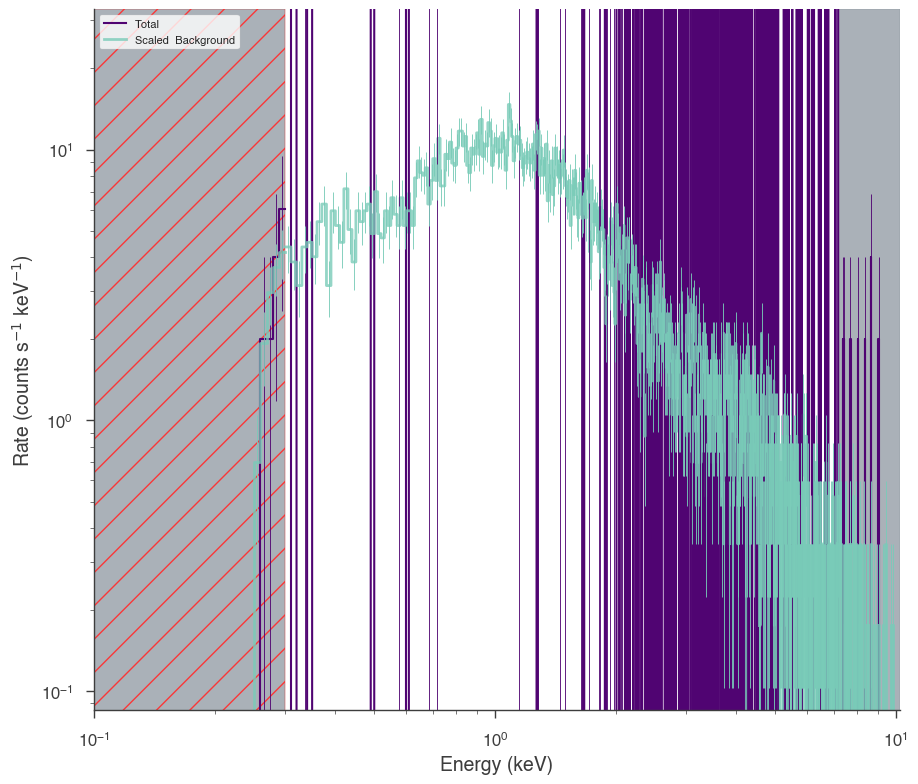

In [4]:
trigger = "GRB110731A"
dec = -28.546
ra = 280.52

p = Path("datasets/xrt")

xrt = OGIPLike(
    "XRT",
    observation=get_path_of_data_file(p / "xrt_src.pha"),
    background=get_path_of_data_file(p / "xrt_bkg.pha"),
    response=get_path_of_data_file(p / "xrt.rmf"),
    arf_file=get_path_of_data_file(p / "xrt.arf"),
)


fig = xrt.view_count_spectrum()
ax = fig.get_axes()[0]
_ = ax.set_xlim(1e-1)

04:18:00 INFO      bad channels shown in red hatching                                          ]8;id=314654;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=805778;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#3007\3007]8;;\
                                                                                                                   

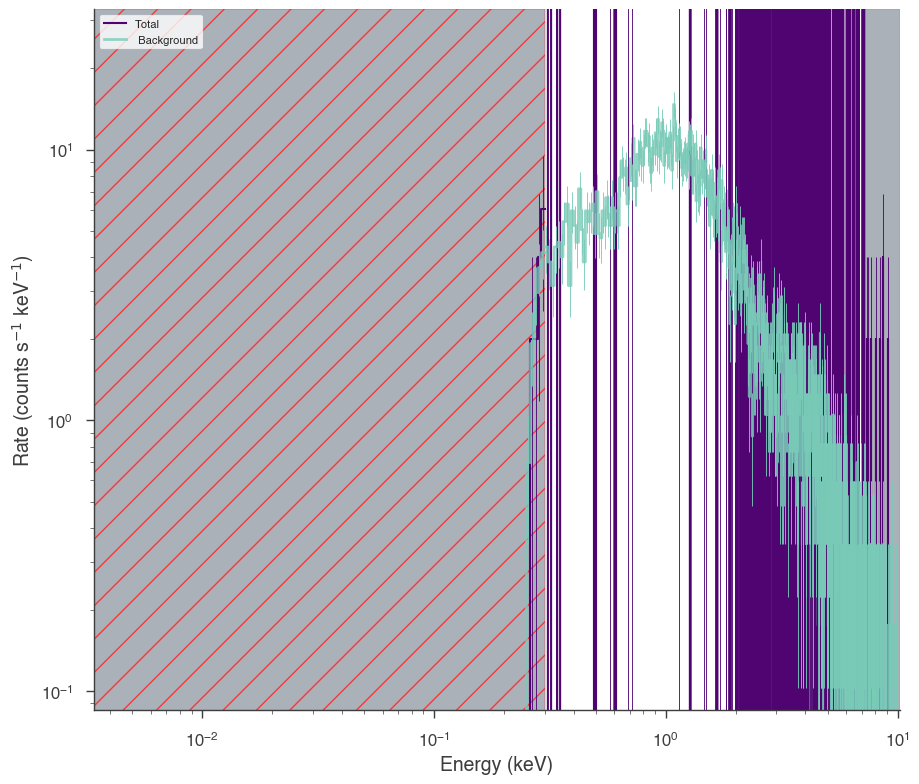

In [5]:
fit = xrt.view_count_spectrum(scale_background=False)

## Load GBM data

Load all the GBM data you need and make appropriate background, source time, and energy selections. Make sure to check the light curves!

In [6]:
trigger_number = "bn110731465"
gbm_data = download_GBM_trigger_data(trigger_number, detectors=["n3"])

Loading PHAII Spectra:   0%|          | 0/1757 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

04:18:20 INFO      Auto-determined polynomial order: 1                                ]8;id=640878;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=239272;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

04:18:44 INFO      None 1-order polynomial fit with the mle method                               ]8;id=337986;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=274210;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=257133;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=572386;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=886406;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=809757;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

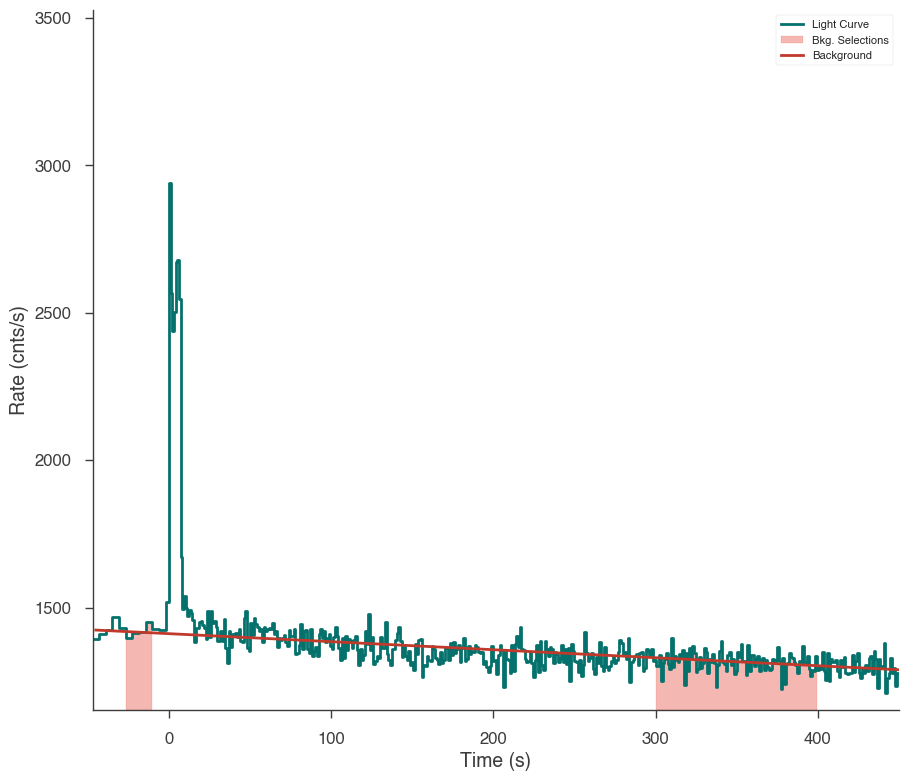

In [7]:
# Select the time interval
src_selection = "100.169342-150.169342"
bkg_selection = ["-25.0--10.0", "300-400"]
ts = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
    name="gbm_n3",
    cspec_or_ctime_file=gbm_data["n3"]["cspec"],
    rsp_file=gbm_data["n3"]["rsp"],
)


ts.set_background_interval(*bkg_selection)
ts.save_background("n3_bkg.h5", overwrite=True)
fig = ts.view_lightcurve(-50, 450)

04:18:47 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=615182;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=749816;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 100.169342-150.169342 for gbm_n3                      ]8;id=861036;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=192928;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

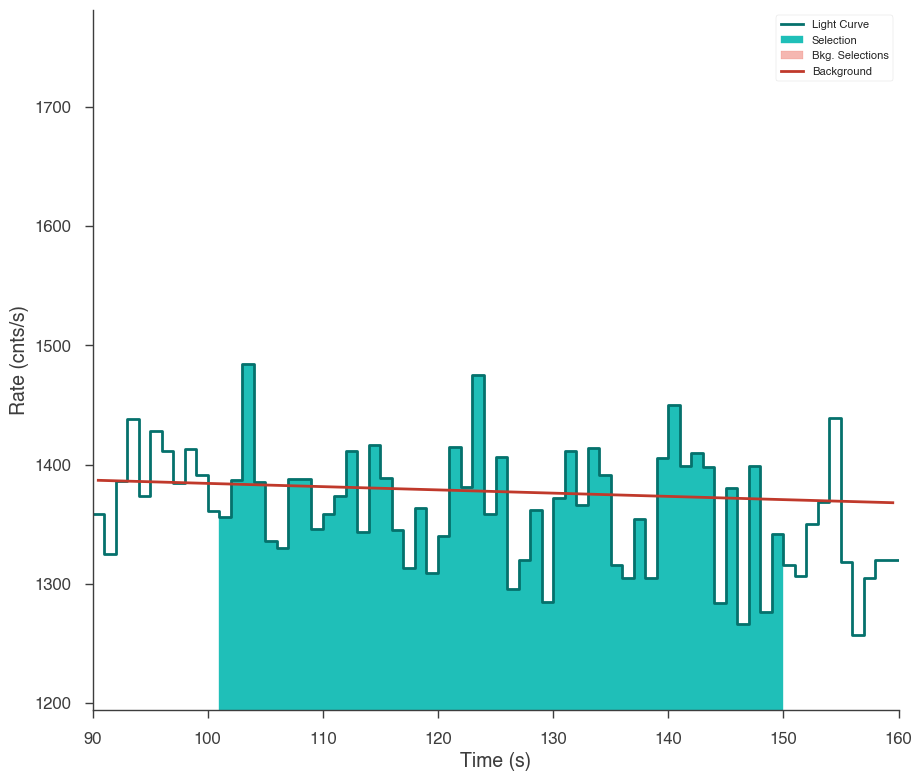

In [8]:
ts = TimeSeriesBuilder.from_gbm_tte(
    "gbm_n3",
    tte_file=gbm_data["n3"]["tte"],
    rsp_file=gbm_data["n3"]["rsp"],
    restore_background="n3_bkg.h5",
)


ts.set_active_time_interval(src_selection)

fig = ts.view_lightcurve(90, 160)

In [9]:
nai3 = ts.to_spectrumlike()

04:18:48 INFO      Auto-probed noise models:                                                    ]8;id=68263;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=374808;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=212345;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=646514;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=401986;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=583018;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

Make energy selections and check them out

         INFO      Range 8-900 translates to channels 4-123                                    ]8;id=969289;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=925641;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

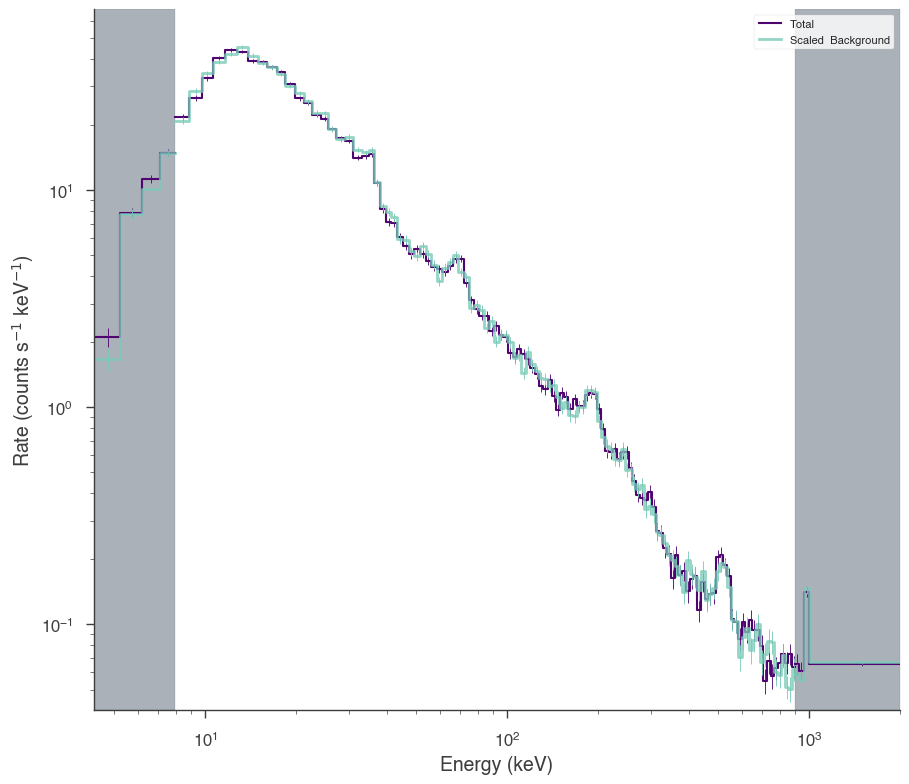

In [10]:
nai3.set_active_measurements("8-900")
fig = nai3.view_count_spectrum()

## Setup the model

**astromodels** allows you to use XSPEC models if you have XSPEC installed.
Set all the normal parameters you would in XSPEC and build a model the normal **3ML/astromodels** way! Here we will use the ```phabs``` model from XSPEC and mix it with powerlaw model in astromodels.


### With XSPEC

In [11]:
xspec_abund("angr")

spectral_model = XS_phabs() * XS_zphabs() * Powerlaw()


spectral_model.nh_1 = 0.101
spectral_model.nh_1.bounds = (None, None)
spectral_model.nh_1.fix = True

spectral_model.nh_2 = 0.1114424
spectral_model.nh_2.fix = True
spectral_model.nh_2.bounds = (None, None)
spectral_model.redshift_2 = 0.618
spectral_model.redshift_2.fix = True

 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)


### With astromodels PHABS

We can build the exact same models in native astromodels thanks to **Dominique Eckert**.
Here, there is no extra function for redshifting the absorption model, just pass a redshift.


In [12]:
phabs_local = PhAbs(NH=0.101)
phabs_local.NH.fix = True
phabs_local.redshift.fix = True
phabs_src = PhAbs(NH=0.1114424, redshift=0.618)
phabs_src.NH.fix = True
phabs_src.redshift.fix = True
pl = Powerlaw()
spectral_model_native = phabs_local * phabs_src * pl

## Setup the joint likelihood

Create a point source object and model.

Load the data into a data list and create the joint likelihood


### With XSPEC models
First we will fit with the XSPEC model

In [13]:
ptsrc = PointSource(trigger, ra, dec, spectral_shape=spectral_model)
model = Model(ptsrc)

#### Fitting

In [14]:
data = DataList(xrt, nai3)

jl = JointLikelihood(model, data, verbose=False)
model.display()

04:18:49 INFO      set the minimizer to minuit                                             ]8;id=773631;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=938016;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (2):
--------------------

                                       value min_value max_value  \
GRB110731A.spectrum.main.composite.K_3   1.0       0.0    1000.0   
GRB110731A...index_3                   -2.01     -10.0      10.0   

                                                  unit  
GRB110731A.spectrum.main.composite.K_3  keV-1 s-1 cm-2  
GRB110731A...index_3                                    

Fixed parameters (8):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

Best fit values:

,result,unit
parameter,,
GRB110731A.spectrum.main.composite.K_3,(1.83 +/- 0.07) x 10^-1,1 / (cm2 keV s)
GRB110731A.spectrum.main.composite.index_3,-1.93 +/- 0.05,


Correlation matrix:

1.00,-0.57
-0.57,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
XRT,2064.191129
gbm_n3,983.140118
total,3047.331247


Values of statistical measures:

,statistical measures
AIC,6098.677382
BIC,6108.054092


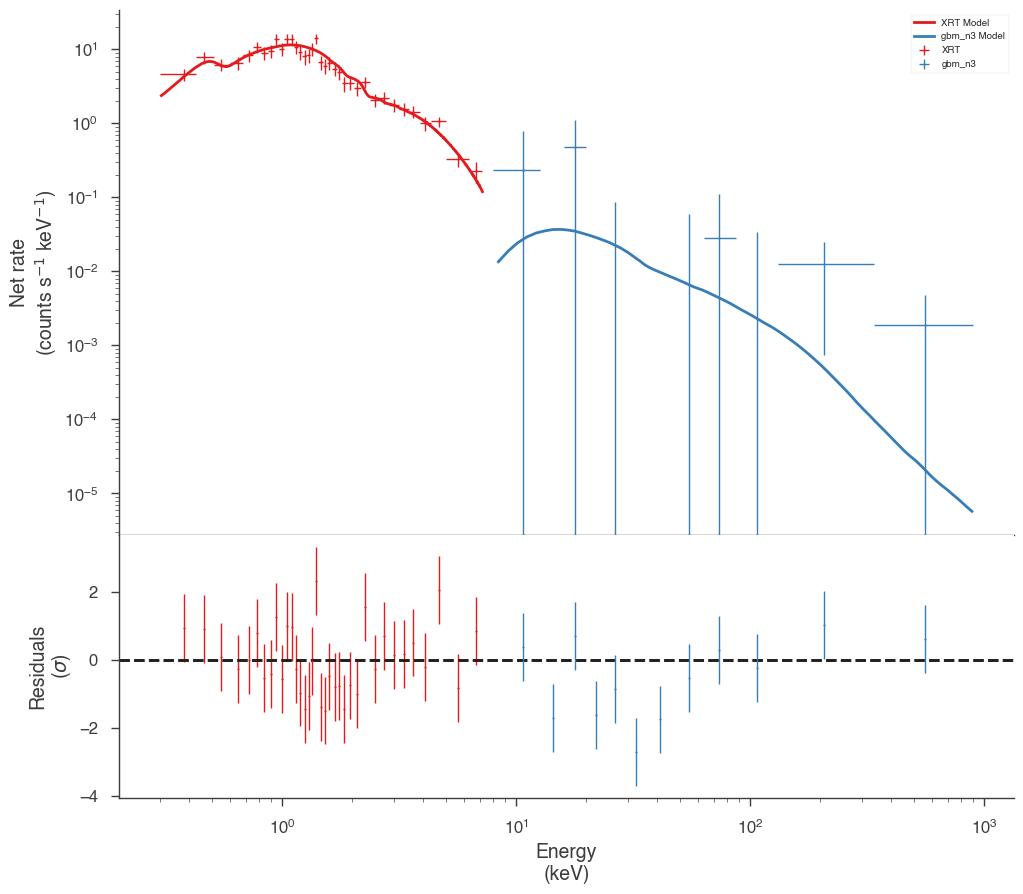

In [15]:
res = jl.fit()
fig = display_spectrum_model_counts(jl, min_rate=[0.5, 0.1])

Profiling likelihood:   0%|          | 0/50 [00:00<?, ?it/s]

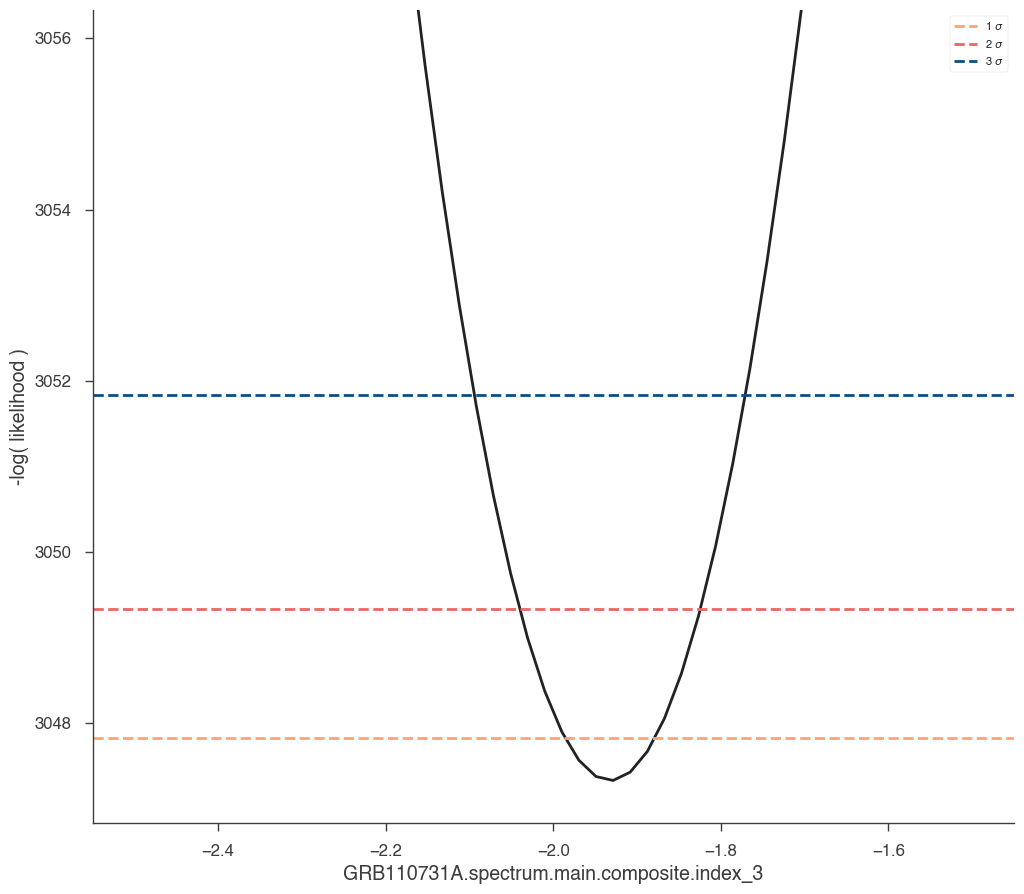

In [16]:
res = jl.get_contours(spectral_model.index_3, -2.5, -1.5, 50)

Profiling likelihood:   0%|          | 0/1250 [00:00<?, ?it/s]

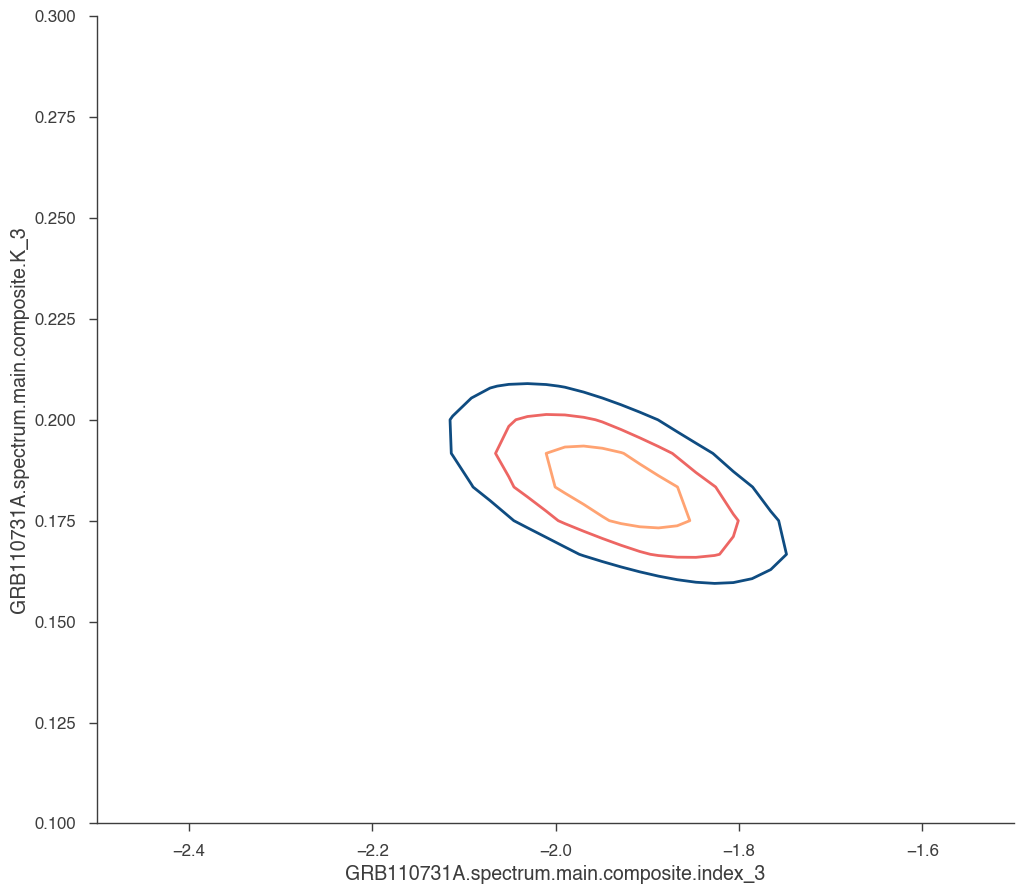

In [17]:
_ = jl.get_contours(
    spectral_model.K_3, 0.1, 0.3, 25, spectral_model.index_3, -2.5, -1.5, 50
)

processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

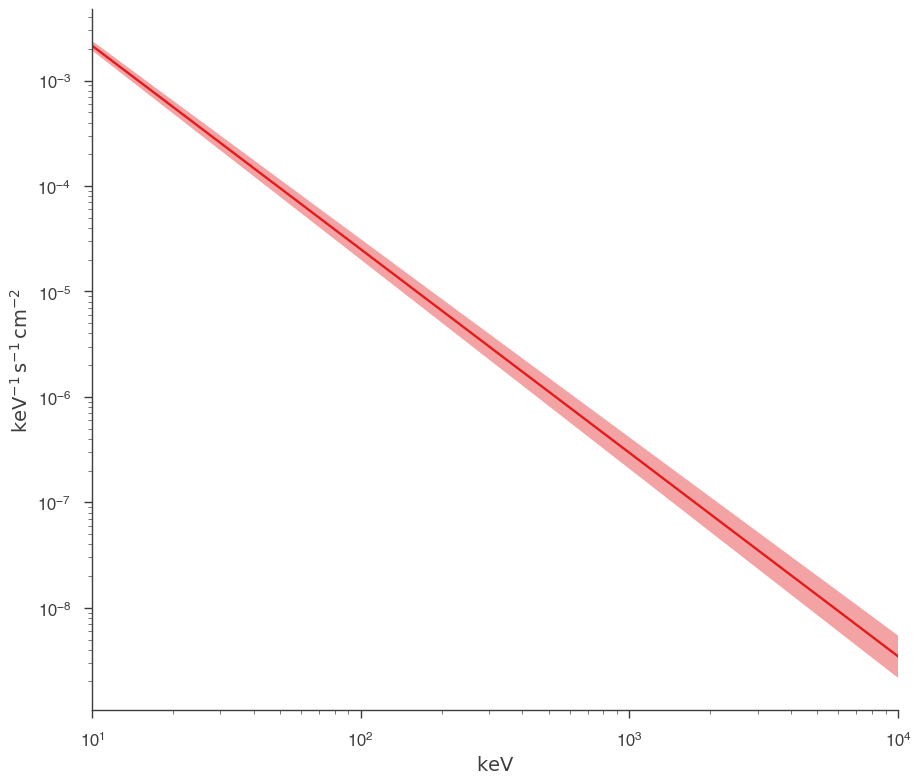

In [18]:
fig = plot_spectra(jl.results, show_legend=False, emin=0.01 * u.keV)

### Fit with astromodels PhAbs

Now lets repeat the fit in pure astromodels.

In [19]:
ptsrc_native = PointSource(trigger, ra, dec, spectral_shape=spectral_model_native)
model_native = Model(ptsrc_native)

#### Fitting

In [20]:
data = DataList(xrt, nai3)

jl_native = JointLikelihood(model_native, data, verbose=False)
model.display()

04:29:49 INFO      set the minimizer to minuit                                             ]8;id=529343;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=334334;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (2):
--------------------

                                           value min_value max_value  \
GRB110731A.spectrum.main.composite.K_3  0.183083       0.0    1000.0   
GRB110731A...index_3                   -1.932241     -10.0      10.0   

                                                  unit  
GRB110731A.spectrum.main.composite.K_3  keV-1 s-1 cm-2  
GRB110731A...index_3                                    

Fixed parameters (8):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

Best fit values:

,result,unit
parameter,,
GRB110731A.spectrum.main.composite.K_3,(1.83 +/- 0.07) x 10^-1,1 / (cm2 keV s)
GRB110731A.spectrum.main.composite.index_3,-1.93 +/- 0.05,


Correlation matrix:

1.00,-0.57
-0.57,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
XRT,2064.181385
gbm_n3,983.140038
total,3047.321423


Values of statistical measures:

,statistical measures
AIC,6098.657734
BIC,6108.034444


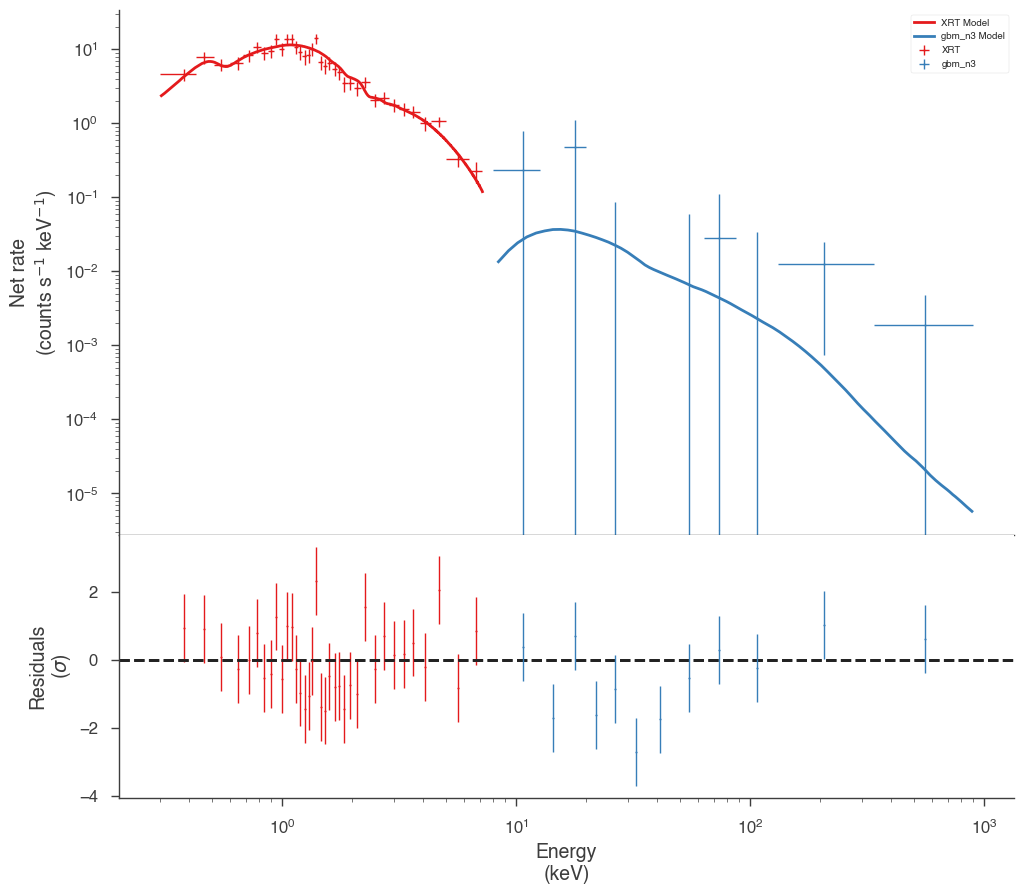

In [21]:
res = jl_native.fit()
fig = display_spectrum_model_counts(jl_native, min_rate=[0.5, 0.1])

processing MLE analyses:   0%|          | 0/2 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

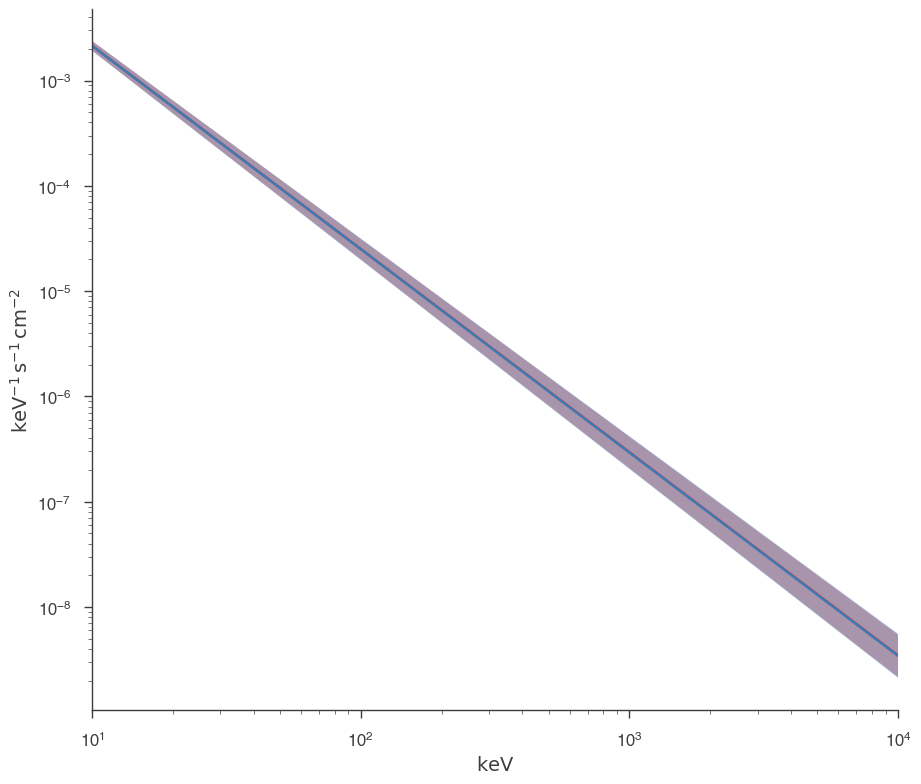

In [22]:
fig = plot_spectra(jl.results, jl_native.results, show_legend=False, emin=0.01 * u.keV)

Both approaches give the same answer as they should.